In [1]:
import torch
import torchvision
import os
import glob
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import shutil
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# custom loss functions from
# https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388#:~:text=Dice%20Coefficient&text=Dice%20coefficient%20is%20a%20measure,while%200%20indicates%20no%20overlap.&text=Dice%20Loss%20%3D%201%20%E2%80%94%20Dice%20Coefficient.
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    # add sigmoid since we take it out to use BCEWithLogitsLoss
    dicescore = dice_loss(nn.functional.sigmoid(inputs), target)
    bcescore = nn.BCEWithLogitsLoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [3]:
# pathway for image folder for training
imagePath = '/project/trlab/CellposeDataset/Train'
maskPath = '/project/trlab/CellposeDataset/Mask'

imagePaths = []
maskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    imagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    maskPaths.append(data_path)
    
# pathway for image folder for validation
imagePath = '/project/trlab/CellposeDataset/Test'
maskPath = '/project/trlab/CellposeDataset/TestMask'

valImagePaths = []
valMaskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    valImagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    valMaskPaths.append(data_path)

In [4]:
# Create Dataset class
class TrainDataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, maskPaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        
    def transform(self, image, mask):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float16')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Transfer to device
        image = image.to(device)
        mask = mask.to(device)
        
        # Random crop (not gonna do this for this run through since the images are all different sizes)
        #i, j, h, w = T.RandomCrop.get_params(image, output_size=(512, 512))
        #image = TF.crop(image, i, j, h, w)
        #mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-90,90)
            image = TF.rotate(image,angle)
            mask = TF.rotate(mask,angle)
            
        # Random Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, 3, 0.15)
            
        # Random sharpness
        sharpness = random.random()
        shift = random.uniform(0.2,1.8)
        if sharpness > 0.5:
            image = TF.adjust_sharpness(image, shift)
            
        # Random contrast not sure why this isn't working, current documentation says one channel tensors are fine
        # but it's throwing an error saying you need 3 channels
        #contrast = random.random()
        #if contrast > 0.5:
        #    image = TF.adjust_contrast(image, 2)
        #elif contrast < 0.25:
        #    image = TF.adjust_contrast(image, 0.5)
        
        # Random brightness
        brightness = random.random()
        shift = random.uniform(0.2,1.8)
        if brightness > 0.5:
            image = TF.adjust_brightness(image, shift)
            
        # Random Affine
        shearx = random.randint(-45,45)
        sheary = random.randint(-45,45)
        transx = random.randint(-20,20)
        transy = random.randint(-20,20)
        if random.random() > 0.5:
            image = TF.affine(image, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            mask = TF.affine(mask, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            
        # pad to correct size for UNet
        #image, pads = pad_to(image,32)
        #mask, pads = pad_to(mask,32)
        image = TF.center_crop(image, [512,512])
        mask = TF.center_crop(mask, [512,512])

        return image, mask
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        #mask = cv2.imdecode(np.fromfile(maskPath, dtype=np.uint16), cv2.IMREAD_UNCHANGED)
        mask = Image.open(maskPath)
        mask = np.array(mask)
        mask = cv2.convertScaleAbs(mask) # convert to uint8
        ret, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY) # binarize the mask

        # use RandomChoice with only ony composed transform so it applies the same way to both
        #transform = T.RandomChoice([T.Compose([T.AutoAugment(T.AutoAugmentPolicy.IMAGENET), T.ToTensor()])])
        image, mask = self.transform(image, mask)
            
        return (image, mask)

In [5]:
# Create Dataset class
class ValDataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, maskPaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        
    def transform(self, image, mask):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float32')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Transfer to device
        image = image.to(device)
        mask = mask.to(device)
        
        image = TF.center_crop(image, [512,512])
        mask = TF.center_crop(mask, [512,512])

        return image, mask
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        mask = Image.open(maskPath)
        mask = np.array(mask)
        mask = cv2.convertScaleAbs(mask) # convert to uint8
        ret, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY) # binarize the mask

        image, mask = self.transform(image, mask)
            
        return (image, mask)

In [6]:
torch.manual_seed(1)

train_dataset = TrainDataset(imagePaths = imagePaths,
                             maskPaths = maskPaths
                            )

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 16,
                                           shuffle = True)


val_dataset = ValDataset(imagePaths = valImagePaths,
                         maskPaths = valMaskPaths,
                        )
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                         batch_size = 16,
                                         shuffle = False
                                        )

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.ConvBlock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), #inplace=True can slightly reduce memory usage
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.ConvBlock(x)
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.ConvBlock = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        s = self.ConvBlock(x) #skip connection
        p = self.pool(s) #pass maxpool2d to next layer of network
        return (p, s)
    
#decoder just for autoencoder, change for UNet
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(out_channels, out_channels)

    def forward(self, p):
        x = self.upConv(p)
        return self.ConvBlock(x)
    
#decoder for UNet
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.ConvBlock = ConvBlock(in_channels, out_channels)

    def forward(self, p, s):
        x = self.upConv(p)
        x = torch.cat([x, s], dim=1)
        return self.ConvBlock(x)

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        
        # Load pretrained ResNet34
        trainedresnet34 = torch.load('/project/trlab/Pretrain Resnet/pretrainedResnetStateDict.pth')
        
        # Load pre-trained ResNet34 as encoder
        self.encoder = models.resnet34()
        self.encoder.fc = nn.Linear(512, 4)
        self.encoder.load_state_dict(trainedresnet34)
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder.fc = nn.Identity()
        
        # Contracting path (left side of U-Net)
        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        
        # Expanding path (right side of U-Net)
        self.upconv1 = UpBlock(1024, 512)
        self.upconv2 = UpBlock(512, 256)
        self.upconv3 = UpBlock(256, 128)
        self.upconv4 = UpBlock(128, 64)
        
        self.upConvAgain1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.upConvAgain2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.upConvAgain3 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.upConvAgain4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.upConvAgain5 = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2)
        
        # Final output layer
        self.output_layer = nn.Conv2d(64, num_classes, kernel_size=1)
        self.activation = nn.Sigmoid()
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512,1024)
        
    def forward(self, x):
        # Contracting path
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        s1 = self.encoder.layer1(x)
        p1 = self.pool(s1)
        s2 = self.encoder.layer2(p1)
        p2 = self.pool(s2)
        s3 = self.encoder.layer3(p2)
        p3 = self.pool(s3)
        s4 = self.encoder.layer4(p3)
        p4 = self.pool(s4)
        
        b = self.bottleneck(p4)
        
        # Expanding path with skip connections

        
        d1 = self.upconv1(b, s4)
        d1 = self.upConvAgain1(d1)
        d2 = self.upconv2(d1, s3)
        d2 = self.upConvAgain2(d2)
        d3 = self.upconv3(d2, s2)
        d3 = self.upConvAgain3(d3)
        d4 = self.upconv4(d3, s1)
        d4 = self.upConvAgain4(d4)
        
        last = self.output_layer(d4)
        last = self.upConvAgain5(last)
        
        return self.activation(last)

# Creating an instance of the UNet model
model = UNet(num_classes=1)


In [9]:
# initialize model
model.to(device)
 
# Validation using MSE Loss function
loss_function = nn.BCEWithLogitsLoss()
#loss_function = nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 3e-4,
                             weight_decay = 1e-8
                            )

In [10]:
epochs = 200
count = 1
outputs = []
losses = []
valLosses=[]
#test_losses = []

# modify training loop to use automatic mixed precision

# convert model to half precision to save memory
#model.half()

# need to keep batch norm layers at fp32
#for layer in model.modules():
#    if isinstance(layer, nn.BatchNorm2d):
#        layer.float()

scaler = torch.cuda.amp.GradScaler(enabled=True)
    
model.train()
for epoch in range(epochs):
    runningLoss = 0
    runningValLoss = 0

    for (i,(image, mask)) in enumerate(train_loader):
        model.train()
        
        image = image.to(device)
        mask = mask.to(device)

        with torch.cuda.amp.autocast():
            # Output of UNet
            reconstructed = model(image)

            # Calculating the loss function
            #loss = loss_function(reconstructed, mask)
            #loss = dice_loss(reconstructed, mask)
            loss = dice_loss(reconstructed, mask)
            runningLoss = runningLoss + loss.item()
            
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
    for (j,(image, mask)) in enumerate(val_loader):
        model.eval()
        image = image.to(device)
        mask = mask.to(device)
        reconstructed = model(image)
        loss = dice_loss(reconstructed, mask)
        runningValLoss = runningValLoss + loss.item()
        
       
    # Storing the losses in a list for plotting
    losses.append(runningLoss/len(train_loader))
    valLosses.append(runningValLoss/len(val_loader))
    outputs.append((epochs, image, reconstructed))
    print("epoch", count, "finished")
    count = count + 1

/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 1 finished
epoch 2 finished
epoch 3 finished
epoch 4 finished
epoch 5 finished
epoch 6 finished
epoch 7 finished
epoch 8 finished
epoch 9 finished
epoch 10 finished
epoch 11 finished
epoch 12 finished
epoch 13 finished
epoch 14 finished
epoch 15 finished


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 15.77 GiB total capacity; 14.33 GiB already allocated; 9.12 MiB free; 14.35 GiB reserved in total by PyTorch)

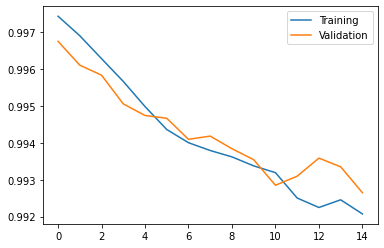

In [12]:
plt.plot(np.arange(15),losses)
plt.plot(np.arange(15),valLosses)
plt.legend(['Training', 'Validation'])

In [ ]:
model_scripted = torch.jit.script(model)
model_scripted.save('scriptedResnetUNet.pt')

#after this cell, restart kernel to clear gpu memory

In [ ]:
#load with:
device = 'cuda'
model = torch.jit.load('scriptedResnetUnet.pt')
model.to(device)
model.train()

import torch
import torchvision
import os
import glob
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF

In [ ]:
# custom loss functions from
# https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388#:~:text=Dice%20Coefficient&text=Dice%20coefficient%20is%20a%20measure,while%200%20indicates%20no%20overlap.&text=Dice%20Loss%20%3D%201%20%E2%80%94%20Dice%20Coefficient.
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    # add sigmoid since we take it out to use BCEWithLogitsLoss
    dicescore = dice_loss(nn.functional.sigmoid(inputs), target)
    bcescore = nn.BCEWithLogitsLoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [ ]:
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 3e-4,
                             weight_decay = 1e-8
                            )

In [ ]:
# pathway for image folder
imagePath = "/project/trlab/imagePath"
maskPath = "/project/trlab/maskPath"

# try with single image
#imagePath = "/project/trlab/SingleIm"
#maskPath = "/project/trlab/SingleMask"

imagePaths = []
maskPaths = []
for data_path in sorted(glob.glob(imagePath + '/*')):
    imagePaths.append(data_path)
    
for data_path in sorted(glob.glob(maskPath + '/*')):
    maskPaths.append(data_path)

In [ ]:
# Create Dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, maskPaths):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        
    def transform(self, image, mask):
        # standardize to values between 0 and 1 for faster convergence
        image = image/255.0
        image = image.astype('float16')
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Transfer to device
        image = image.to(device)
        mask = mask.to(device)
        
        # Random crop
        i, j, h, w = T.RandomCrop.get_params(image, output_size=(512, 512))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        # Random rotation
        if random.random() > 0.5:
            angle = random.randint(-90,90)
            image = TF.rotate(image,angle)
            mask = TF.rotate(mask,angle)
            
        # Random Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, 3, 0.15)
            
        # Random sharpness
        sharpness = random.random()
        shift = random.uniform(0.2,1.8)
        if sharpness > 0.5:
            image = TF.adjust_sharpness(image, shift)
            
        # Random contrast not sure why this isn't working, current documentation says one channel tensors are fine
        # but it's throwing an error saying you need 3 channels
        #contrast = random.random()
        #if contrast > 0.5:
        #    image = TF.adjust_contrast(image, 2)
        #elif contrast < 0.25:
        #    image = TF.adjust_contrast(image, 0.5)
        
        # Random brightness
        brightness = random.random()
        shift = random.uniform(0.2,1.8)
        if brightness > 0.5:
            image = TF.adjust_brightness(image, shift)
            
        # Random Affine
        shearx = random.randint(-45,45)
        sheary = random.randint(-45,45)
        transx = random.randint(-20,20)
        transy = random.randint(-20,20)
        if random.random() > 0.5:
            image = TF.affine(image, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            mask = TF.affine(mask, translate=(transx,transy), shear=(shearx,sheary), angle=0, scale=1)
            
        #image = image.type('torch.HalfTensor')
        #mask = image.type('torch.HalfTensor')

        return image, mask
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]
        
        image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imdecode(np.fromfile(maskPath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

        # use RandomChoice with only ony composed transform so it applies the same way to both
        #transform = T.RandomChoice([T.Compose([T.AutoAugment(T.AutoAugmentPolicy.IMAGENET), T.ToTensor()])])
        image, mask = self.transform(image, mask)
            
        return (image, mask)

In [ ]:
# from torchvision import datasets
torch.manual_seed(1)

dataset = Dataset(imagePaths = imagePaths,
                  maskPaths = maskPaths
                 )

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = 8,
                                     shuffle = True)
test_dataset.indices
train_dataset.indices

In [ ]:
epochs = 100
count = 1
outputs = []
losses = []

# modify training loop to use automatic mixed precision

# convert model to half precision to save memory
#model.half()

# need to keep batch norm layers at fp32
#for layer in model.modules():
#    if isinstance(layer, nn.BatchNorm2d):
#        layer.float()

scaler = torch.cuda.amp.GradScaler(enabled=True)
    
model.train()
for epoch in range(epochs):
    runningLoss = 0
    for (i,(image, mask)) in enumerate(loader):
        
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.cuda.amp.autocast():
            # Output of UNet
            reconstructed = model(image)
       
            # Calculating the loss function
            #loss = loss_function(reconstructed, mask)
            #loss = dice_loss(reconstructed, mask)
            loss = bce_dice_loss(reconstructed, mask)
            runningLoss = runningLoss + loss.item()
            
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        
        # autocast backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
       
    # Storing the losses in a list for plotting
    losses.append(runningLoss/len(loader))
    outputs.append((epochs, image, reconstructed))
    print("epoch", count, "finished")
    count = count + 1